<a href="https://colab.research.google.com/github/9645258/aiffel/blob/main/02_nlp/%5BGD_12%5Dnlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GD NLP 12 : 번역가는 대화에도 능하다**

- **멋진 챗봇 만들기**

- **챗봇 훈련데이터 전처리 과정이 체계적으로 진행되었는가?**  
챗봇 훈련데이터를 위한 전처리와 augmentation이 적절히 수행되어 3만개 가량의 훈련데이터셋이 구축되었다.  

- **transformer 모델을 활용한 챗봇 모델이 과적합을 피해 안정적으로 훈련되었는가?**  
과적합을 피할 수 있는 하이퍼파라미터 셋이 적절히 제시되었다.  

- **챗봇이 사용자의 질문에 그럴듯한 형태로 답하는 사례가 있는가?**  
주어진 예문을 포함하여 챗봇에 던진 질문에 적절히 답하는 사례가 제출되었다.  


## **1. 데이터 준비**

### **1-1. 라이브러리 import**

In [ ]:
import re
import os
import io
import time
import nltk
import gensim
import random
import numpy as np
import pandas as pd
import tensorflow as tf

from konlpy.tag import Mecab
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu 
from nltk.translate.bleu_score import SmoothingFunction

import warnings
warnings.filterwarnings('ignore')

### **1-2. 데이터 import**

In [ ]:
dataset = pd.read_csv('~/aiffel/GD_12/data/ChatbotData .csv')

### **1-3. 데이터 정제**

- **데이터 확인**

In [ ]:
dataset

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


- **총 데이터 수 확인**

In [ ]:
len(dataset)

11823

- **불필요 컬럼 삭제**

In [ ]:
dataset.drop(('label'), axis = 'columns', inplace = True)

- **데이터 확인**

In [ ]:
display(dataset.sample(10))

,Q,A
6687,설레였던게 언젠인지,곧 설레는 순간이 올 거예요.
5342,3개월째,아프지 마요.
9168,나는 아직 고백안했는데 소문이 나서 짝남이 알게 됐어.,많이 당황했겠어요.
3791,인턴하고 싶어,얼른 알아보세요.
3649,이 무리에 낀게 잘못인가,지금도 늦지 않았어요.
9020,관심있는 여자애한테 의미있는 선물을 주고 싶은데 뭘 주면 좋아할까요?,필요한 게 뭔지 살펴보세요.
11100,좋아하는 사람 환심 살 수 있는 방법 좀.,그 분이 좋아하는 것을 알아봐요.
5571,괜찮은게 아닌가봐,안 괜찮아도 돼요.
6048,다시 사랑한다고 했는데.,마음이 허전하가봐요.
9551,너무 사랑하는데 동거해도될까?,책임질 수 있다면 하고 싶은 대로 하세요.


- **데이터 정보 확인**  
    - 총 데이터 수: 11,823개
    - 결측치: 0개  
    - 중복 데이터: 73개  

In [ ]:
dataset.info()
dup = dataset.duplicated()
dup = dup.value_counts()[True]

print(f"Dupliacted Data Num: {dup:,}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
dtypes: object(2)
memory usage: 184.9+ KB
Dupliacted Data Num: 73


- **중복 데이터 제거**

In [ ]:
dataset.drop_duplicates(inplace = True)
print(f"최종 데이터 수: {len(dataset)}개")

최종 데이터 수: 11750개


### **1-4. 데이터 정규화**

- **영문 소문자화 및 영어, 한글, 숫자, 주요 특수문자 제외 모든 문자 제거 함수 제작**  

In [ ]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    
    sentence = re.sub(r"([0-9?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z0-9ㄱ-ㅎ|가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

- **데이터 정규화**

In [ ]:
dataset["Q"] = dataset["Q"].apply(preprocess_sentence)
dataset["A"] = dataset["A"].apply(preprocess_sentence)

- **데이터 확인**

In [ ]:
display(dataset.head(10))

,Q,A
0,1 2 시 땡 !,하루가 또 가네요 .
1,1 지망 학교 떨어졌어,위로해 드립니다 .
2,3 박 4 일 놀러가고 싶다,여행은 언제나 좋죠 .
3,3 박 4 일 정도 놀러가고 싶다,여행은 언제나 좋죠 .
4,ppl 심하네,눈살이 찌푸려지죠 .
5,sd카드 망가졌어,다시 새로 사는 게 마음 편해요 .
6,sd카드 안돼,다시 새로 사는 게 마음 편해요 .
7,sns 맞팔 왜 안하지,잘 모르고 있을 수도 있어요 .
8,sns 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요 .
9,sns 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요 .


### **1-5. 데이터 토큰화**

- **Mecab을 활용한 토큰화**

In [ ]:
m = Mecab()

In [ ]:
dataset["Q"] = dataset["Q"].apply(lambda x: " ".join(m.morphs(x)))
dataset["A"] = dataset["A"].apply(lambda x: " ".join(m.morphs(x)))

- **데이터 확인**

In [ ]:
display(dataset.sample(10))

,Q,A
76,같이 수영장 가 기 로 했 어,즐거운 시간 보내 고 오 세요 !
10304,썸남 이 춥 다고 옷 잠궈 주 는 데 설레 .,다정 한 사람 이 네요 .
1729,목표 가 없 어,목표 는 있 으면 좋 겠 지만 없 다고 미리 걱정 할 필요 없 어요 . 생길 거 예요 .
10940,인연 이 있 다고 생각 해 ?,저 랑 당신 도 인연 이 죠 .
9122,나 부담 스러워 하 면 어쩌 지 ?,좀 더 편안 하 게 대해 보 세요 .
4420,차 팔 았 더니 불편 하 네,불편 함 을 조금 감수 해 보 세요 .
5423,sns 에서 다른 이성 이랑 대화 하 는 걸 보 니 화 가 나,sns 보 지 마세요 .
3337,오늘 도 평온 해,내일 도 평온 하 길 바라 요 .
4580,치맥 먹 으면서 축구 봐야지,보다 보 면 재미있 어요 .
11636,차 없 으면 데이트 못 해 ?,걸어다니 면서 하 는 데이트 가 진정한 데이트 죠 .


- **디코더 문장 시작/끝 토큰 추가**

In [ ]:
dataset["A"] = dataset["A"].apply(lambda x: "<sos> " + x + " <eos>")

- **데이터 확인**

In [ ]:
display(dataset.sample(10))

,Q,A
2413,생리통 너무 심해,<sos> 약 을 먹 거나 병원 에 가 보 세요 . <eos>
5533,계속 시간 을 갖 자는 의미 는 뭔가 ?,<sos> 생각 할 시간 과 정리 할 시간 이 필요 하 다는 거 겠 죠 . <eos>
11686,친구 결혼식 에서 축가 준비 중,<sos> 친구 가 좋 아 하 겠 어요 . <eos>
8239,집착 은 절대 하 지 말 아야지,<sos> 잘 하 고 있 어요 . <eos>
10473,약속 을 계속 미루 는 썸남,<sos> 약속 을 소홀히 생각 하 는 사람 은 믿음직 스럽 지 못해요 . <eos>
9308,남자 친구 가 너무 객관 적 이 야 .,<sos> 좀 더 내 편 이 되 어 달 라고 해 보 세요 . <eos>
10530,여자 가 더 사랑 해서 한 결혼,<sos> 누가 더 사랑 하 는지 는 상관 없 어요 . <eos>
440,꽃다발 준비 했 어,<sos> 멋진 선물 이 네요 . <eos>
627,나 만 뒤처지 는 느낌 이 야,<sos> 스스로 경쟁 해야 하 고 이겨야 한다는 강박 관념 에 사로잡히 지 마세요...
4183,조카 입학 선물,<sos> 가방 은 어때요 . <eos>


- **토크나이저 생성**

In [ ]:
def get_tokenizer(corpus, vocab_size):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='',
        oov_token="<UNK>",
        num_words=vocab_size
    )
    corpus_input = [sentence.split() for sentence in corpus]
    tokenizer.fit_on_texts(corpus_input)
    
    if vocab_size is not None:
        words_frequency = [w for w,c in tokenizer.word_index.items() if c >= vocab_size + 1]
        for w in words_frequency:
            del tokenizer.word_index[w]
            del tokenizer.word_counts[w]
    
    return tokenizer

concat = pd.concat([dataset["Q"], dataset["A"]])
tokenizer = get_tokenizer(concat, None)

- **토큰 수 확인**

In [ ]:
print(len(tokenizer.word_index))

6810


- **문장 정수화**

In [ ]:
def encoding_sentence(copus, tokenizer):
    tensor = tokenizer.texts_to_sequences(copus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    return tensor

In [ ]:
enc_tensor = encoding_sentence(dataset["Q"], tokenizer)
dec_tensor = encoding_sentence(dataset["A"], tokenizer)

- **문장 정수화 확인**

In [ ]:
enc_tensor

array([[ 206,  241,  174, ...,    0,    0,    0],
       [ 206, 3322,  531, ...,    0,    0,    0],
       [ 266, 2061,  458, ...,    0,    0,    0],
       ...,
       [6250,   15,   55, ...,    0,    0,    0],
       [ 207,  111,   13, ...,    0,    0,    0],
       [  70,  278,  157, ...,    0,    0,    0]], dtype=int32)

In [ ]:
dec_tensor

array([[   3,  249,    9, ...,    0,    0,    0],
       [   3,  522,   15, ...,    0,    0,    0],
       [   3,  238,   18, ...,    0,    0,    0],
       ...,
       [   3, 2275,   25, ...,    0,    0,    0],
       [   3,   49, 1609, ...,    0,    0,    0],
       [   3, 4610,  157, ...,    0,    0,    0]], dtype=int32)

- **데이터 빈도 시각화 함수 제작**

In [ ]:
def show_sentence_length(sentence_num, title, range_=[0, 500]):
    plt.figure(figsize=(13, 5))
    plt.suptitle(title, fontsize=14)
    
    plt.subplot(1, 2, 1)
    plt.hist(sentence_num, bins=range_[1], range=range_, facecolor='b', label='train')
    plt.xlabel('Number of question')
    plt.ylabel('Count of question')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(sentence_num, labels=['token counts'], showmeans=True)

    plt.show()
    
    print(f"최대 길이: {np.max(sentence_num):d}")
    print(f"최소 길이: {np.min(sentence_num):d}")
    print(f"평균 길이: {np.mean(sentence_num):.3f}")
    print(f"표준편차: {np.std(sentence_num):.3f}", end = "\n\n")
    
    percentile25 = np.percentile(sentence_num, 25)
    percentile50 = np.percentile(sentence_num, 50)
    percentile75 = np.percentile(sentence_num, 75)
    percentileIQR = percentile75 - percentile25
    percentileMAX = percentile75 + percentileIQR * 1.5
    
    print(f"25%: {percentile25:.3f}")
    print(f"50%: {percentile50:.3f}")
    print(f"75%: {percentile75:.3f}")
    print(f"100%: {percentileMAX:.3f}")
    print(f"사분범위: {percentileIQR:.3f}")

- **데이터 문장 길이 확인 함수 제작**

In [ ]:
def get_sentence_len(tensor):
    counts = []
    for sentence in tensor.tolist():
        try:
            idx = sentence.index(0)
            counts.append(idx)
        except:
            counts.append(len(sentence))
    return counts

In [ ]:
enc_counts = get_sentence_len(enc_tensor)
dec_counts = get_sentence_len(dec_tensor)

- **라벨 Q의 문장 정보**

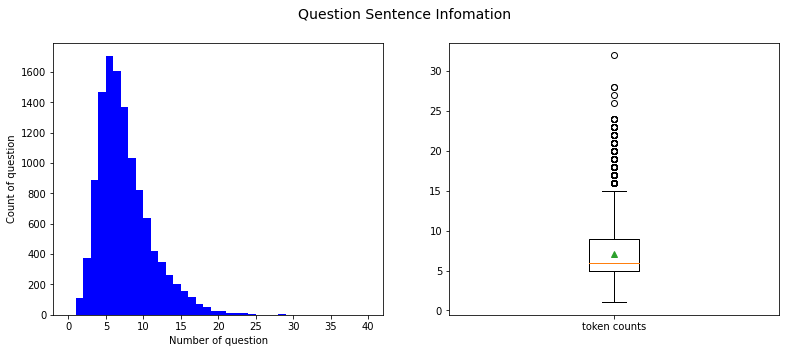

최대 길이: 32
최소 길이: 1
평균 길이: 7.035
표준편차: 3.524

25%: 5.000
50%: 6.000
75%: 9.000
100%: 15.000
사분범위: 4.000


In [ ]:
show_sentence_length(enc_counts, "Question Sentence Infomation", [0, 40])

- **라벨 A의 문장 정보**

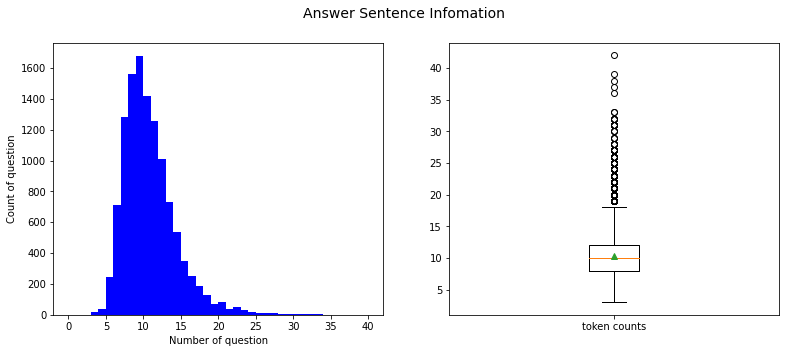

최대 길이: 42
최소 길이: 3
평균 길이: 10.377
표준편차: 3.575

25%: 8.000
50%: 10.000
75%: 12.000
100%: 18.000
사분범위: 4.000


In [ ]:
show_sentence_length(dec_counts, "Answer Sentence Infomation", [0, 40])

- **토큰 사용 빈도 확인**

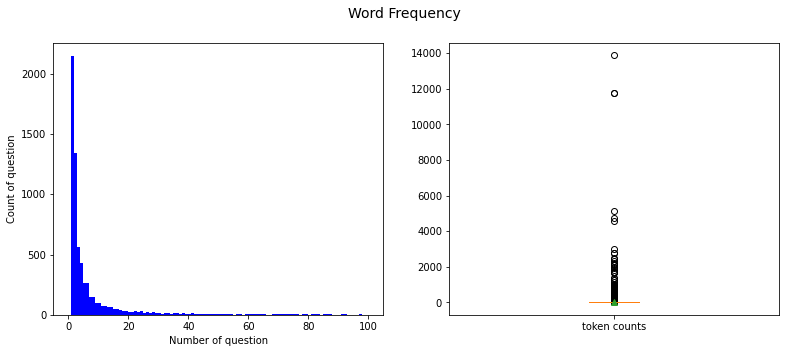

최대 길이: 13870
최소 길이: 1
평균 길이: 30.048
표준편차: 310.114

25%: 1.000
50%: 2.000
75%: 7.000
100%: 16.000
사분범위: 6.000


In [ ]:
freq = [value for value in tokenizer.word_counts.values()]
show_sentence_length(freq, "Word Frequency", [0, 100])

- **사용빈도 4분위에 해당하는 토큰 수 확인**

In [ ]:
def wordNumByFreq(tokenizer, freq_num):
    sorted_freq = sorted(tokenizer.word_counts.items(), key=lambda x: x[1])
    for idx, (_, freq) in enumerate(sorted_freq):
        if freq > freq_num: break;
    return idx

print(wordNumByFreq(tokenizer, 16))

5872


- **최종 토크나이저 생성**

In [ ]:
concat = pd.concat([dataset["Q"], dataset["A"]])
tokenizer = get_tokenizer(concat, 5872)

In [ ]:
q = dataset["Q"].apply(lambda x: len(tokenizer.texts_to_sequences([x])[0]) <= 15)
a = dataset["A"].apply(lambda x: len(tokenizer.texts_to_sequences([x])[0]) <= 18)
dataset = dataset[q & a]

- **최종 토크나이저 수 확인**

In [ ]:
print(len(tokenizer.word_index))

5872


## **2. Test 데이터 분할**

- **데이터 분할**

In [ ]:
test_dataset = dataset[:100]
dataset = dataset[100:]

- **Test 분할 데이터 확인**

In [ ]:
display(test_dataset.sample(10))

,Q,A
33,가족 들 이랑 여행 갈 거 야,<sos> 좋 은 생각 이 에요 . <eos>
10,sns 보 면 나 만 빼 고 다 행복 해 보여,<sos> 자랑 하 는 자리 니까요 . <eos>
14,가난 한 자 의 설움,<sos> 돈 은 다시 들어올 거 예요 . <eos>
56,감기약 이 없 어,<sos> 병원 가 세요 . <eos>
30,가족 들 이랑 서먹 해,<sos> 다 들 바빠서 이야기 할 시간 이 부족 했 나 봐요 . <eos>
60,감정 컨트롤 을 못 하 겠 어,<sos> 그건 습관 이 에요 . <eos>
104,거짓말 이 거짓말 을 낳 아,<sos> 진실 된 말 을 하 려고 노력 해 보 세요 . <eos>
69,강아지 키우 고 싶 은데 역시 안 돼 겠지,<sos> 먼저 생활 패턴 을 살펴 보 세요 . <eos>
37,가족 한테 스트레스 풀 었 어,<sos> 정말 후회 할 습관 이 에요 . <eos>
58,감미 로운 목소리 좋 아,<sos> 저 도 듣 고 싶 네요 . <eos>


- **Train 분할 데이터 확인**

In [ ]:
display(dataset.sample(10))

,Q,A
11541,짝 녀 와 자연 스럽 게 친해질 수 있 는 방법 좀 .,<sos> 공통 관심사 를 찾아보 세요 . <eos>
7066,여전히 괴롭 다,<sos> 이별 은 몹시 도 괴로우 니까요 . <eos>
4498,초콜릿 만들 어서 줄까 ?,<sos> 좋 아 할 거 예요 . <eos>
5928,너무 사랑 했 고 너무 그리워 하 는 그 사람 .,<sos> 애틋 한 사랑 을 하 셨 네요 . <eos>
8292,참 허무 하 네 .,<sos> 마음 이 허전 한가 봐요 . <eos>
1478,마음 이 싱숭생숭 해서 자꾸 글 을 쓰 게 되 네,<sos> 글 쓰 면서 정리 가 될 거 예요 . <eos>
5161,혼자 가 편하 대,<sos> 상대방 을 이해 해 주 세요 . <eos>
10270,썸 과 연인 사이,<sos> 이제 선택 할 상황 이 네요 . <eos>
9723,매일 카페 에서 그 의 뒷모습 만 보 게 돼 .,<sos> 이제 앞모습 을 보 세요 . <eos>
1225,대학 가 야 하나 ?,<sos> 장단점 을 분석 해 보 세요 . <eos>


## **3. 데이터 증강**

### **3-1. 사전 훈련 임베딩 모델 import**

In [ ]:
w2v = gensim.models.Word2Vec.load('~/aiffel/GD_12/data/ko.bin')

### **3-2. 데이터 증강**

- **데이터 증강 함수 생성**

In [ ]:
def lexical_sub(sentence, word2vec, enc_arg=True):
    toks = sentence.split()
    if not enc_arg:   #<sos>, <eos> 토큰 제외
        toks = toks[1:-1]

    _from = random.choice(toks)
    
    try:
        _to = word2vec.most_similar(_from)[0][0]
    except:
        return "_"
    
    res = ""
    for tok in sentence.split():
        if tok == _from:
            res += _to + " "
        else:
            res += tok + " "
    return res

In [ ]:
def argument_data(dataset, word2vec, enc_arg=True):
    qna = "Q" if enc_arg else "A"
    arg = dataset[qna].apply(lambda x: lexical_sub(x, word2vec, enc_arg))
    
    arg_data = dataset.copy()
    arg_data[qna] = arg
    
    arg_data = arg_data[arg_data[qna] != "_"]
    return arg_data

- **데이터 증강**

In [ ]:
enc_alpha = argument_data(dataset, w2v, True)
dec_alpha = argument_data(dataset, w2v, False)

In [ ]:
enc_idx = set(dataset.index)
enc_alpha_idx = set(enc_alpha.index)
dec_alpha_idx = set(dec_alpha.index)

vet = enc_idx & enc_alpha_idx & dec_alpha_idx
vet = list(vet)[0]

print(f"Q 기본 문장: {dataset['Q'][vet]}")
print(f"Q 증강 문장: {enc_alpha['Q'][vet]}")
print(f"A 기본 문장: {dataset['A'][vet]}")
print(f"A 증강 문장: {dec_alpha['A'][vet]}")

Q 기본 문장: 걱정 좀 없이 살 고 싶 다 .
Q 증강 문장: 걱정 좀 없이 살아오 고 싶 다 . 
A 기본 문장: <sos> 누구 나 걱정 은 있 어요 . <eos>
A 증강 문장: <sos> 누구 나 걱정 은 있 어요 는데 <eos> 


### **3-3. 데이터 결합**

- **데이터 결합 진행**

In [ ]:
dataset = pd.concat([dataset, enc_alpha, dec_alpha])
dataset = dataset.sample(frac=1)

- **최종 데이터 수**

In [ ]:
len(dataset)

29952

- **최종 데이터 확인**

In [ ]:
display(dataset.head(10))

,Q,A
3587,월세 너무 저렴,<sos> 돈 을 얼른 모아야 할 이유 가 생겼 네요 . <eos>
5226,회사 를 차리 고 겠 다,<sos> 확신 이 있 을 때 시작 해 보 세요 . <eos>
5546,공허 함 이 크 네,<sos> 제 가 채워 줄게요 . <eos>
4283,현재 행복 해,<sos> 현재 를 즐기 세요 ! <eos>
5474,거의 매일 술,<sos> 술 많이 드 시 면 더 무너 져요 . <eos>
7248,과연 차단 이 안 되 있 을까 ? ?,<sos> 관심 을 끄 세요 . <eos>
6050,다시 와도 싫 다고 단호 시키 게 말 해야지,<sos> 잘 할 수 있 을 거 예요 . <eos>
9681,마음 이 예쁜 사람 만나 고 싶 어,<sos> 마음 이 예쁜 사람 을 찾 ㄴ다는 게 더 힘들 거 예요 . <eos>
7508,이별 은 냉정 할수록 좋 은 것 같 아,<sos> 감정 적 일수록 더 힘들 어 지 기 만이 할 거 예요 . <eos>
441,꽃바구니 선물 이랑 과일 바구니 선물 뭐 가 좋 아 ?,<sos> 받 는 사람 이 부럽 네요 . <eos>


## **4. 데이터 벡터화**

- **데이터 확인**

- **정수 인코딩**

In [ ]:
enc_tensor = encoding_sentence(dataset["Q"], tokenizer)
dec_tensor = encoding_sentence(dataset["A"], tokenizer)

- **데이터 확인**

In [ ]:
enc_tensor

array([[2936,   56, 4357, ...,    0,    0,    0],
       [ 339,   31,  812, ...,    0,    0,    0],
       [1148,  304,    5, ...,    0,    0,    0],
       ...,
       [  13,   22,    6, ...,  150,   11,    2],
       [ 996,  394,  180, ...,    0,    0,    0],
       [  69,    1, 1177, ...,    0,    0,    0]], dtype=int32)

In [ ]:
dec_tensor

array([[   3,  226,    8, ...,    0,    0,    0],
       [   3,  511,    5, ...,    0,    0,    0],
       [   3,  144,    9, ...,    0,    0,    0],
       ...,
       [   3, 2007,    8, ...,    0,    0,    0],
       [   3, 1137,   31, ...,    0,    0,    0],
       [   3,   69,   23, ...,    0,    0,    0]], dtype=int32)

- **최종 데이터 수**

In [ ]:
len(dataset)

29952

## **5. 모델 생성**

### **5-1. Positional Encoding**

In [ ]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i)/d_model)
    
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]
    
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

### **5-2. MultiHeadAttention**

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

### **5-3. Position-wise Feed-Forward Network**

In [ ]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

### **5-4. Mask Layer**

In [ ]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

### **5-5. Encoder Layer**

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

### **5-6. Decoder Layer**

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
       
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### **5-7. Encoder**

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

### **5-8. Decoder**

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### **5-9. Transformer**

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(
        self,
        n_layers, d_model, n_heads, d_ff,
        src_vocab_size, tgt_vocab_size,
        pos_len,
        dropout=0.2,
        shared=True
    ):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

            
    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [ ]:
transformer = Transformer(
    n_layers=2,
    d_model=128,
    n_heads=8,
    d_ff=128,
    dropout=0.5,
    pos_len=200,
    shared=True,
    src_vocab_size=5872, tgt_vocab_size=5872
)

### **5-10. Optimizer**

In [ ]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

## **6. 모델 학습**

### **6-1. 학습 함수 생성**

In [ ]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

### **6-2. 학습 진행**

In [ ]:
def model_fit(enc_train, dec_train, model, epochs, batch_size):
    for epoch in range(epochs):
        total_loss = 0

        idx_list = list(range(0, enc_train.shape[0], batch_size))
        random.shuffle(idx_list)
        t = tqdm(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = \
            train_step(
                enc_train[idx:idx+batch_size],
                dec_train[idx:idx+batch_size],
                model,
                optimizer
            )

            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
            

model_fit(enc_tensor, dec_tensor, transformer, epochs=10, batch_size=64)

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]

### **6-3. 학습 결과 확인**

In [ ]:
def translate(sentence, model, tokenizer, enc_tensor, dec_tensor):
    enc_maxlen = enc_tensor.shape[-1]
    dec_maxlen = dec_tensor.shape[-1]

    sos_idx = tokenizer.word_index['<sos>']
    eos_idx = tokenizer.word_index['<eos>']

    sentence = preprocess_sentence(sentence)

    m = Mecab()
    sentence = m.morphs(sentence)

    _input = tokenizer.texts_to_sequences([sentence])
    _input = tf.keras.preprocessing.sequence.pad_sequences(
        _input,
        maxlen=enc_maxlen,
        padding='post'
    )

    ids = []
    output = tf.expand_dims([sos_idx], 0)

    for i in range(dec_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(
            _input, output
        )

        predictions, enc_attns, dec_attns, dec_enc_attns = model(
            _input, output, enc_padding_mask, combined_mask, dec_padding_mask
        )

        predicted_id = tf.argmax(
            tf.math.softmax(predictions, axis=-1)[0, -1]
        ).numpy().item()

        if predicted_id == eos_idx:
            result = tokenizer.sequences_to_texts([ids])
            return result

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tokenizer.sequences_to_texts([ids])
    return result

In [ ]:
test_sentences = ["지루하다, 놀러가고 싶어.", "오늘 일찍 일어났더니 피곤하다.", "간만에 여자친구랑 데이트 하기로 했어.", "집에 있는다는 소리야."]

for sentence in test_sentences:
    ans = translate(sentence, transformer, tokenizer, enc_tensor, dec_tensor)[0]
    print(f"Quenstion: {sentence:<40}")
    print(f"Answer: {ans:<40}", "\n")

Quenstion: 지루하다, 놀러가고 싶어.                          
Answer: 저 도 요 !                                  

Quenstion: 오늘 일찍 일어났더니 피곤하다.                       
Answer: <UNK> 을 많이 하 는 건 어떨까 요 ?                 

Quenstion: 간만에 여자친구랑 데이트 하기로 했어.                   
Answer: 좋 은 만남 만 하 셨 네요 .                        

Quenstion: 집에 있는다는 소리야.                            
Answer: 온전 하 고 있 었 나 봐요 .                        



## **7. 모델 평가**

### **7-1. Beam Search 및 BLEU 함수 정의**

- **모델 입력 및 출력 함수**

In [ ]:
def calc_prob(src_ids, tgt_ids, model):
    enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(
        src_ids, tgt_ids
    )
    
    predictions, enc_attns, dec_attns, dec_enc_attns = model(
        src_ids, tgt_ids, enc_padding_mask, combined_mask, dec_padding_mask
    )
    return tf.math.softmax(predictions, axis=-1)

- **Beam Search**

In [ ]:
def beam_search_decoder(
    sentence, model, tokenizer,
    enc_maxlen, dec_maxlen,
    beam_size
):
    sos_idx = tokenizer.word_index['<sos>']
    eos_idx = tokenizer.word_index['<eos>']

    tokens = tokenizer.texts_to_sequences([sentence])
    src_in = tf.keras.preprocessing.sequence.pad_sequences(
        tokens,
        maxlen=enc_maxlen,
        padding='post'
    )

    pred_cache = np.zeros((beam_size * beam_size, dec_maxlen), dtype=np.long)
    pred = np.zeros((beam_size, dec_maxlen), dtype=np.long)

    eos_flag = np.zeros((beam_size, ), dtype=np.long)
    scores = np.ones((beam_size, ))

    pred[:, 0] = sos_idx

    dec_in = tf.expand_dims(pred[0, :1], 0)
    prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()
    
    
    for seq_pos in range(1, dec_maxlen):
        score_cache = np.ones((beam_size * beam_size, ))

        # init
        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            score_cache[cache_pos:cache_pos+beam_size] = scores[branch_idx]
            pred_cache[cache_pos:cache_pos+beam_size, :seq_pos] = \
            pred[branch_idx, :seq_pos]

        for branch_idx in range(beam_size):
            cache_pos = branch_idx*beam_size

            if seq_pos != 1:   # 모든 Branch를 로 시작하는 경우를 방지
                dec_in = pred_cache[branch_idx, :seq_pos]
                dec_in = tf.expand_dims(dec_in, 0)

                prob = calc_prob(src_in, dec_in, model)[0, -1].numpy()

            for beam_idx in range(beam_size):
                max_idx = np.argmax(prob)

                score_cache[cache_pos+beam_idx] *= prob[max_idx]
                pred_cache[cache_pos+beam_idx, seq_pos] = max_idx

                prob[max_idx] = -1

        for beam_idx in range(beam_size):
            if eos_flag[beam_idx] == -1: continue

            max_idx = np.argmax(score_cache)
            prediction = pred_cache[max_idx, :seq_pos+1]

            pred[beam_idx, :seq_pos+1] = prediction
            scores[beam_idx] = score_cache[max_idx]
            score_cache[max_idx] = -1

            if prediction[-1] == eos_idx:
                eos_flag[beam_idx] = -1
    return pred

- **BLEU 계산 함수**

In [ ]:
def calculate_bleu(reference, candidate, weights=[0.25, 0.25, 0.25, 0.25]):
    return sentence_bleu(
        [reference],
        candidate,
        weights=weights,
        smoothing_function=SmoothingFunction().method1
    )

- **Beam search 및 BLEU 계산 함수**

In [ ]:
def beam_bleu(reference, ids, tokenizer, verbose=False):
    reference = reference.split()

    total_score = 0.0
    for _id in ids:
        seq2text = tokenizer.sequences_to_texts([_id])[0]
        _idx =  seq2text.find("<eos>")
        seq2text = seq2text[6:_idx]
        candidate = seq2text.split()
        score = calculate_bleu(reference, candidate)
        
        if verbose:
            print("Reference:".ljust(10), " ".join(reference))
            print("Candidate:".ljust(10), " ".join(candidate))
            print("BLEU:".ljust(10), f"{calculate_bleu(reference, candidate):.3f}", end="\n\n")
        
        total_score += score
        
    return total_score / len(ids)

- **Beam search 예문 및 BLEU 출력**

In [ ]:
idx = 30
test_enc_sentence = test_dataset["Q"][idx]

test_dec_tensor = encoding_sentence(test_dataset["A"], tokenizer)
test_dec_sentence = tokenizer.sequences_to_texts([test_dec_tensor[idx]])[0]
_idx = test_dec_sentence.find("<eos>")
test_dec_sentence = test_dec_sentence[6:_idx]


ids = beam_search_decoder(
    test_enc_sentence,
    transformer, tokenizer,
    enc_tensor.shape[-1], dec_tensor.shape[-1],
    beam_size=5
)

bleu = beam_bleu(test_dec_sentence, ids, tokenizer, verbose=True)

### **7-2. Test data BLEU**

In [ ]:
enc_maxlen = enc_tensor.shape[-1]
dec_maxlen = dec_tensor.shape[-1]

aver_bleu = 0
for _, que, ans in test_dataset.itertuples():
    ids = beam_search_decoder(
        que,
        transformer, tokenizer,
        enc_maxlen, dec_maxlen,
        beam_size=5
    )
    
    test_dec_sentence = tokenizer.sequences_to_texts([que])[0]
    _idx = test_dec_sentence.find("<eos>")
    test_dec_sentence = test_dec_sentence[6:_idx]
    
    aver_bleu += beam_bleu(test_dec_sentence, ids, tokenizer, verbose=False)

In [ ]:
print(f"Test Data BLEU: {aver_bleu:.3f}")

Test Data BLEU: 0.576


### **7-3. 최종 결과**

최종 Test의 BLEU는 0.576으로, 이해할 수 있는 양호한 번역으로 준수한 성능으로 평가되지만, 평가 수준에 비해 생각보다 실제 나타난 문장이 매끄럽지 않은 경우가 많다.